In [87]:
using IJulia, Test
using Distributions
using LinearAlgebra
using Plots
using SingularIntegrals, ClassicalOrthogonalPolynomials
using FFTW

Warning: all of this was written with terrible naming conventions, because normally I just autolint everything I write

Also, none of the functions have specified types yet

In [2]:
P = ChebyshevU()
println(size(P)) # continuous array, then countable indexing

(ℵ₁, ℵ₀)


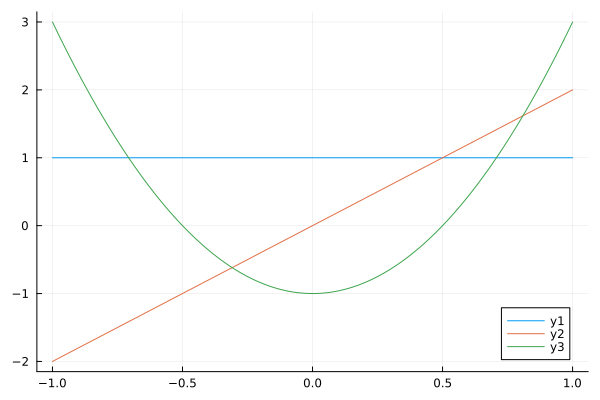

In [3]:
plot((-1:0.01:1),P[-1:0.01:1,1:3])
#P["continuous set of values","countable index of polynomial"]

In [4]:
function semi(x, σ2 = 1)
    """
    Semicircle distribution with variance σ2
    """
    if abs(x) > 2 * sqrt(σ2)
        return 0
    else
        return sqrt(4*σ2 - x^2) / ( 2 * pi * σ2)
    end
end

Jinv_p = z -> z - √(z - 1) * √(z + 1)
J = w -> 1/2 * (w + 1/w)
M_ab = (x,a,b) -> (a + b)/2 + (b - a) * x /2 # from (-1, 1) to (a, b)
M_ab_inv = (y,a,b) -> (2*y - (a + b))/(b - a) # from (a, b) to (-1, 1)

sgn = y -> (y > 0) - (y < 0)

#dJinv_p = z -> 1 - √(z + 1)/(2 * √(z - 1)) - √(z - 1)/(2 * √(z + 1))
dM_ab_inv = (y,a,b) -> 2/(b - a)

function dJinv_p(z)
    if z == 1 || z == -1
        return Inf * -1 * z
    end
    w = √(z + 1)/√(z - 1)
    1 - w/2 - 1/(2*w)
end

function d2Jinv_p(z)
    if z == 1 || z == -1
        return Inf * z
    end
    w = √(z - 1)/√(z + 1)
    -1/4 * ((w - 1/w)/(z-1) + (1/w - w)/(z+1))
end

ε = cbrt(eps())
@test isapprox((Jinv_p(1.2+0.4im + ε) + Jinv_p(1.2+0.4im - ε) - 2 * Jinv_p(1.2+0.4im))/ε^2,
    d2Jinv_p(1.2+0.4im)
    ; rtol = 10^-3)

Test Passed

In [5]:
function G_standard_semi(z)
    Jinv_p(M_ab_inv(z, -2, 2))
end
function G_standard_semi_inv(z)
    M_ab(J(z), -2, 2)
end

function chebyshevnodes(a,b,n)
    [(a+b)/2 + (b-a)/2 * cos((2k-1)/2n * pi) for k = 1:n]
end
function unitcirclenodes(n)
    [exp(pi * (-1 + 2/n * k)im) for k=0:n-1]
end

unitcirclenodes (generic function with 1 method)

In [6]:
# compute point cloud
m = 20
d_M = vec(unitcirclenodes(m)*[x for x in chebyshevnodes(-1,1,2*m+1) if x > eps()]');
z_μ_M = [M_ab(J(x), -2, 2) for x in d_M if imag(x) >= eps()]
y_M = [G_standard_semi(y) for y in z_μ_M]
y_M = [y for y in y_M if isapprox(G_standard_semi(G_standard_semi_inv(y)), y)];

# inverse cauchy transform
G_free_inv = z -> G_standard_semi_inv(z) .+ G_standard_semi_inv(z) - (1/z);

# prune points
y_m = [y for y in y_M if sgn(imag(y)) != sgn(imag(G_free_inv(y)))]

# initial guess for support
a_0 = max(real(G_standard_semi(-2+0im)), real(G_standard_semi(-2+0im)))
b_0 = min(real(G_standard_semi(2+0im)), real(G_standard_semi(2+0im)))

dG_standard_semi = z -> dJinv_p(M_ab_inv(z, -2, 2)) * dM_ab_inv(z, -2, 2)
d2G_standard_semi = z -> d2Jinv_p(M_ab_inv(z, -2, 2)) * dM_ab_inv(z, -2, 2)^2
dG_standard_semi_inv = z -> 1 / (dG_standard_semi(G_standard_semi_inv(z)))
d2G_standard_semi_inv = z ->  - d2G_standard_semi(G_standard_semi_inv(z)) / (dG_standard_semi(G_standard_semi_inv(z))) ^ 3

# derivative of inverse cauchy transform
dG_free_inv = z -> dG_standard_semi_inv(z) + dG_standard_semi_inv(z) + 1/z^2 # needs changing

ε = sqrt(eps())
@test isapprox((G_standard_semi(2.1 + 0.2im + ε) - G_standard_semi(2.1 + 0.2im))/ε,
    dG_standard_semi(2.1 + 0.2im)
    ; rtol = 10^-6)
@test isapprox((G_standard_semi_inv(0.1 + 0.2im + ε) - G_standard_semi_inv(0.1 + 0.2im))/ε,
    dG_standard_semi_inv(0.1 + 0.2im)
    ; rtol = 10^-6)
ε = cbrt(eps())
@test isapprox((G_standard_semi(2.1 + 0.2im + ε) + G_standard_semi(2.1 + 0.2im - ε) - 2*G_standard_semi(2.1 + 0.2im))/ε^2,
    d2G_standard_semi(2.1 + 0.2im)
    ; rtol = 10^-3)
@test isapprox((G_standard_semi_inv(0.1 + 0.2im + ε) + G_standard_semi_inv(0.1 + 0.2im - ε) - 2*G_standard_semi_inv(0.1 + 0.2im))/ε^2,
    d2G_standard_semi_inv(0.1 + 0.2im)
    ; rtol = 10^-3)

Test Passed

In [88]:
# newton method for support
#newton(dG_standard_semi_inv, d2G_standard_semi_inv, b_0)
#newton(dG_standard_semi_inv, d2G_standard_semi_inv, a_0)

dG_free_inv_real = z -> real(dG_free_inv(Complex(z)))

# bisection method  for support
ξ_b = bisection(dG_free_inv_real, 0, b_0; tol=10^-6, maxits = 30)
ξ_a = bisection(dG_free_inv_real, 0, a_0; tol=10^-6, maxits = 30)
a,b = G_free_inv(ξ_a), G_free_inv(ξ_b)

(-2.8284271247462325, 2.8284271247462316)

In [89]:
# least squares for ψ_k

n = length(y_m)
A = [Jinv_p(M_ab_inv(G_free_inv(y_m[j]),a,b))^k for j=1:n, k=1:n]
V = [real.(A);imag.(A)]

f = [real.(y_m);imag.(y_m)]

Q, R̂ = qr(V)
Q̂ = Q[:,1:n]

ψ_k = R̂ \ Q̂'f ./ pi

@test norm(V * ψ_k .* pi - f) < 10^-9
@test isapprox(ψ_k[1], 4 / (pi * (b-a)), rtol = 10^-8) # required to make sure measure produced is a normalized measure

Test Passed

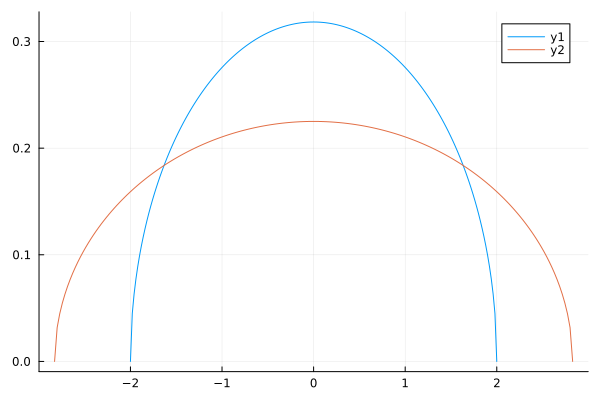

In [90]:
x = a:(b-a)/200:b
ps = P[M_ab_inv.(x, a, b),1:n] * ψ_k
ps = ps .* 2 .* .√(x .- a) .* .√(b .- x) ./ (b - a)

plot(-2:0.02:2, semi.(-2:0.02:2))
plot!(x, ps)

In [61]:
function newton(f, df, x_0; tol=10^-6, maxits = 20)
    x = x_0
    for i=1:maxits
        if abs(f(x)) < tol
            return x
        end
        x = x - f(x)/df(x)
    end
    error("failed to converge in maxits")
end
function bisection(f, x_l, x_r; tol=10^-6, maxits = 40, info=false)
    for i=1:maxits
        if info
            println(x_l, x_r)
        end
        x_m = (x_l + x_r)/2
        if abs(f(x_m)) < tol
            return x_m
        end
        if info
            println(f(x_l), f(x_m), f(x_r))
        end
        if (f(x_m) > 0) ⊻ (f(x_l) > 0)
            x_r = x_m 
        else
            x_l = x_m
        end
    end
    error("failed to converge in maxits")
end

bisection (generic function with 1 method)

In [11]:
function dinv(invf, df)
    z -> 1/df(inv(z))
end
function d2inv(invf, df, d2f)
    z -> - d2f(invf(z)) / (df(invf(z)))^3
end

d2inv (generic function with 1 method)

In [45]:
# What is a square root decaying measure?
# A square root decaying measure (absolutely continuous wrt Lebesgue) has two properties:
# - A pair (a,b) indicating the support of the measure (which we presume to be an interval)
# - A function ψ(x) which typically doesn't vanish at either a or b (strictly square root decaying)

# Step 1: Expand our function ψ(x) in terms of Chebyshev U(x) polynomials

ψ_x = x -> (4x^2 + 1) / (2 * pi)
#ψ_x = x -> 1 / pi
P = ChebyshevU()
ψ_k = expand(P, ψ_x).args[2]

# Step 2: Compute the Cauchy transform
"""
    Compute the Cauchy transform G_μ of a square root decaying measure supported on one interval.
    
    Parameters:
        z: Complex
            - Point at which G_μ is evaluated at.
    
        ψ_k: 1 x n array, n ∈ ℕ ∪ {∞}
            - Coefficients of expansion of ψ(x) in terms of Chebyshev U polynomials.
    
        a, b: Real, a < b
            - Indicates the support of the measure.
    
        maxterms: Int
            - Max number of terms ψ_k used in expansion of ψ(x).
    """
function CauchyTransformSqrt(z, ψ_k, a, b; maxterms=20)
    ans = 0
    w_0 = Jinv_p(M_ab_inv(z, a, b))
    w = w_0
    for k=1:min(maxterms, length(ψ_k))
        ans += ψ_k[k] * w
        w *= w_0
    end
    pi * ans
end

CauchyTransformSqrt

In [116]:
# Step 3: Compute the Inverse Cauchy transform

"""
    Compute the Inverse Cauchy transform G_μ of a square root decaying measure supported on one interval.
    This is done using a Companion Matrix method.
    
    Parameters:
        z: Complex
            - Point at which G_μ is evaluated at.
    
        ψ_k: 1 x n array, n ∈ ℕ ∪ {∞}
            - Coefficients of expansion of ψ(x) in terms of Chebyshev U polynomials.
    
        a, b: Real, a < b
            - Indicates the support of the measure.
    
        maxterms: Int
            - Max number of terms ψ_k used in expansion of ψ(x).
    
        tol: Float
            - How close eigenvalues need to be to the origin in order to count as a valid inverse to the polynomial problem.
            - To be honest, I don't know if this actually helps or not. Setting it just above 1 seems to be right
            - If it is equal to 1, it sometimes misses solutions due to floating point errors.
"""    
function InvCauchyTransformSqrt(z, ψ_k, a, b; maxterms=20, tol=1+10^-6)   

    # find largest index i which ψ_k[i] is non-zero
    P = ψ_k[1:min(length(ψ_k),maxterms)]
    n = min(length(ψ_k),maxterms)
    while abs(ψ_k[n]) < 10^-9
        n -= 1
    end
    P ./= P[n]
    # lazy convert to complex
    C = zeros(Complex, n, n)
    for i=1:n-1
        C[i+1,i] = 1
        C[i+1,n] = -P[i]
    end
    C[1, n] = z/(pi * ψ_k[n])
    s = eigvals(C)
    if length(s) > 1
        s = [z for z in s if abs(z) < tol]
    end
    if length(s) == 1
        return M_ab.(J.(s), a, b)[1]
    else
        return M_ab.(J.(s), a, b)
    end
    # is this bad practice? it returns a complex if single and a vector if not single.
end
#         println("tried to invert z = ") # too lazy to format strings
#         println(z)
#         println("eigenvalues for potential solutions")
#         println(eigvals(C))
#         scatter(eigvals(C))
#         error("no solution found within the specified tolerance")

InvCauchyTransformSqrt

In [14]:
# Step 4: Compute point cloud required for approximating the Cauchy transform:

function PointCloud(G_a, G_b, supp_c, InvG_b; m = 20)
    """
    Compute the point cloud required to approximate the Cauchy transform G_a⊞b.
    
    Parameters:
        G_a, G_b, InvG_b: Function
            - Respectively, the Cauchy transform of μ_a, μ_b and the inverse Cauchy transform of μ_b.
    
        supp_c: Tuple{Real}
            - Indicates the support of the convolution measure.
    
        m: Int
            - Controls the number of points that are used to sample. In general, increasing m will lead to more sampling points.
    """
    d_M = vec(unitcirclenodes(m)*[x for x in chebyshevnodes(-1,1,2*m+1) if x > eps()]')
    z_μ_M = [M_ab(J(x), supp_c[1], supp_c[2]) for x in d_M if imag(x) >= eps()]
    y_M = [G_a(y) for y in z_μ_M]
    y_M = [y for y in y_M if length(InvG_b(y)) == 1]
    y_M = [y for y in y_M if isapprox(G_b(InvG_b(y)), y)]
end

function PrunePoints(points, InvG_a, InvG_b)
    """
    Prune the points used to evaluate the inverse Cauchy transform of G_a⊞b.
    
    Parameters:
        points: Array{Complex}
            - Point cloud created from the function PointCloud()
        
        InvG_a, InvG_b: Function
            - Respectively, the inverse Cauchy transform of μ_a and μ_b.
    """
    InvG_c = y -> InvG_a(y) .+ InvG_b(y) .- 1 ./ y
    y_m = [y for y in points if length(InvG_c(y)) == 1]
    [y for y in y_m if sgn(imag(y)) != sgn(imag(InvG_c(y)))]
end

PrunePoints (generic function with 1 method)

In [15]:
# Step 5: Compute support of square root decaying measure

function dCauchyTransformSqrt(z, ψ_k, a, b; maxterms=20)
    """
    Compute the derivative of the Cauchy transform G_μ of a square root decaying measure supported on one interval.
    
    Parameters:
        z: Complex
            - Point at which G_μ is evaluated at.
    
        ψ_k: 1 x n array, n ∈ ℕ ∪ {∞}
            - Coefficients of expansion of ψ(x) in terms of Chebyshev U polynomials.
    
        a, b: Real, a < b
            - Indicates the support of the measure.
    
        maxterms: Int
            - Max number of terms ψ_k used in expansion of ψ(x).
    """
    ans = 0
    w_0 = Jinv_p(M_ab_inv(z, a, b))
    w = 1
    for k=1:min(maxterms, length(ψ_k))
        ans += ψ_k[k] * w * k * dJinv_p(M_ab_inv(z, a, b)) * dM_ab_inv(z, a, b)
        w *= w_0
    end
    pi * ans
end

function d2CauchyTransformSqrt(z, ψ_k, a, b; maxterms=20)
    """
    Compute the second derivative of the Cauchy transform G_μ of a square root decaying measure supported on one interval.
    
    Parameters:
        z: Complex
            - Point at which G_μ is evaluated at.
    
        ψ_k: 1 x n array, n ∈ ℕ ∪ {∞}
            - Coefficients of expansion of ψ(x) in terms of Chebyshev U polynomials.
    
        a, b: Real, a < b
            - Indicates the support of the measure.
    
        maxterms: Int
            - Max number of terms ψ_k used in expansion of ψ(x).
    """
    ans = 0
    w_0 = Jinv_p(M_ab_inv(z, a, b))
    w = 1
    for k=1:min(maxterms, length(ψ_k))
        dw = dJinv_p(M_ab_inv(z, a, b)) * dM_ab_inv(z, a, b)
        d2w = d2Jinv_p(M_ab_inv(z, a, b)) * dM_ab_inv(z, a, b)^2
        ans += ψ_k[k] * k * ((k-1) * w/w_0 * dw^2 + w*d2w)
        w *= w_0
    end
    pi * ans
end
test = z -> 2/((z^2-4)^(3/2))
ε = sqrt(eps())
@test isapprox((dCauchyTransformSqrt(-0.1+0.2im + ε, [1/pi], -2, 2) - dCauchyTransformSqrt(-0.1+0.2im , [1/pi], -2, 2))/ε,
    d2CauchyTransformSqrt(-0.1+0.2im, [1/pi], -2, 2)
    ; rtol = 10^-3)

Test Passed

In [48]:
function Support(G_a, G_b, InvG_a, InvG_b, dG_a, dG_b, supp_a, supp_b; tol=10^-6, maxits=40)
    """
        Compute the support of the additive convolution of two measures.
        This is done using a Bisection method.
    
        Parameters:
            G_a, G_b, InvG_a, InvG_b, dG_a, dG_b: Function
                - Respectively, the Cauchy transform of μ_a, μ_b, the inverse Cauchy transform of μ_a and μ_b and the
                  derivatives of the Cauchy transform ofs μ_a and μ_b.
    
        supp_a, supp_b: Tuple{Real}
                - Pairs of Reals representing the supports of μ_a and μ_b.
    
        tol: Float
                - Tolerance for bisection.
        
        maxits: Int
                - Maximum number of iterations for bisection.
    """
    a_0 = max(real(G_a(Complex(supp_a[1]))), real(G_b(Complex(supp_b[1])))) #20
    b_0 = min(real(G_a(Complex(supp_a[2]))), real(G_b(Complex(supp_b[2]))))  
    dInvG_a = z -> 1 / (dG_a(InvG_a(z)))
    dInvG_b = z -> 1 / (dG_b(InvG_b(z)))
    dInvG_c = z -> dInvG_a(z) + dInvG_b(z) + 1/z^2
    dInvG_c_real = z -> real(dInvG_c(Complex(z))) # since some of the calculations involve complex numbers
    ξ_a = bisection(dInvG_c_real, a_0, a_0/2; tol, maxits)
    ξ_b = bisection(dInvG_c_real, b_0/2, b_0; tol, maxits)
    InvG_c = y -> InvG_a(y) + InvG_b(y) - 1/y
    (real(InvG_c(ξ_a)), real(InvG_c(ξ_b)))
end

Support (generic function with 1 method)

In [49]:
# Step 6: Compute the coefficients of the Chebyshev expansion of the convolution

function RecoverMeasureSqrt(InvG_a, InvG_b, supp_c, y_m; residuals=false)
    """
    Recover the coeffiencients of the Chebyshev U expansion of a square root decaying measure.
    This is done using a Least-squares method.
    
    Parameters:
        InvG_a, InvG_b: Function
            - Respectively, the inverse Cauchy transform of μ_a and μ_b.
        
        supp_c: Tuple{Real}
            - Support of the measure of the convolution μ_c.
    
        y_m: Array{Complex}
            - Sampling points for solving the Least-squares problem.
    """
    
    InvG_c = z -> InvG_a(z) .+ InvG_b(z) - (1/z);
    n = length(y_m)
    A = [Jinv_p(M_ab_inv(InvG_c(y_m[j]),supp_c[1],supp_c[2]))^k for j=1:n, k=1:n]
    V = [real.(A);imag.(A)]
    f = [real.(y_m);imag.(y_m)]
    Q, R̂ = qr(V)
    Q̂ = Q[:,1:n]
    sol = R̂ \ Q̂'f ./ pi
    if residuals
        res = pi * V * sol - f
        return sol, res
    else
        return sol
    end
end

RecoverMeasureSqrt (generic function with 1 method)

In [130]:
function PlotSqrtMeasure(ψ_k, supp; points=200, maxterms=20)
    a,b = supp
    P = ChebyshevU()
    x = LinRange(a, b, points+1)
    n = length(ψ_k)
    ps = P[M_ab_inv.(x, a, b),1:n] * ψ_k
    ps = real.(ps .* 2 .* .√(Complex.(x) .- a) .* .√(b .- Complex.(x)) ./ (b - a))
    plot(x, ps)
end

function PlotSqrtMeasure!(ψ_k, supp; points=200, maxterms=20)
    a,b = supp
    P = ChebyshevU()
    x = LinRange(a, b, points+1)
    n = length(ψ_k)
    ps = P[M_ab_inv.(x, a, b),1:n] * ψ_k
    ps = real.(ps .* 2 .* .√(Complex.(x) .- a) .* .√(b .- Complex.(x)) ./ (b - a))
    plot!(x, ps)
end

PlotSqrtMeasure! (generic function with 1 method)

In [100]:
function FreeAdditionSqrt(ψ_a_k, ψ_b_k, supp_a, supp_b; m=10, maxterms=20, tolcomp=1+10^-6, tolbisect = 10^-6, maxitsbisect=40)
    G_a = z -> CauchyTransformSqrt(Complex(z), ψ_a_k, supp_a[1], supp_a[2]; maxterms)
    G_b = z -> CauchyTransformSqrt(Complex(z), ψ_b_k, supp_b[1], supp_b[2]; maxterms)
    InvG_a = z -> InvCauchyTransformSqrt(Complex(z), ψ_a_k, supp_a[1], supp_a[2]; maxterms, tol=tolcomp)
    InvG_b = z -> InvCauchyTransformSqrt(Complex(z), ψ_b_k, supp_b[1], supp_b[2]; maxterms, tol=tolcomp)
    dG_a = z -> dCauchyTransformSqrt(Complex(z), ψ_a_k, supp_a[1], supp_a[2]; maxterms)
    dG_b = z -> dCauchyTransformSqrt(Complex(z), ψ_b_k, supp_b[1], supp_b[2]; maxterms)
    supp_c = Support(G_a, G_b, InvG_a, InvG_b, dG_a, dG_b, supp_a, supp_b; tol=tolbisect, maxits=maxitsbisect)
    y_M = PointCloud(G_a, G_b, supp_c, InvG_b; m)
    y_m = PrunePoints(y_M, InvG_a, InvG_b)
    ψ_c_k = RecoverMeasureSqrt(InvG_a, InvG_b, supp_c, y_m)
    ψ_c_k, supp_c
end

FreeAdditionSqrt (generic function with 1 method)

  0.002890 seconds (13.67 k allocations: 865.875 KiB)


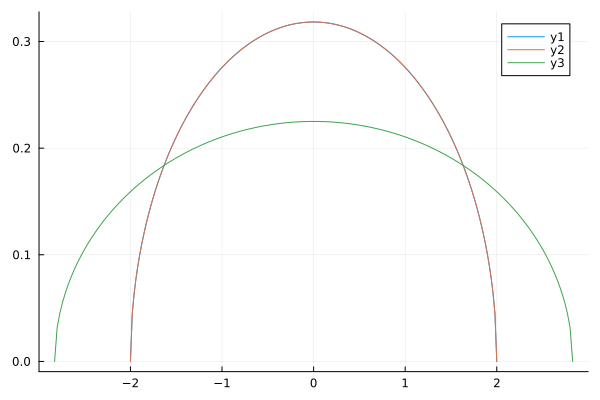

In [131]:
# Free addition of two standard semicircles produces a semicircle of variance 2.
ψ_a_k = [1/pi]
ψ_b_k = [1/pi]
@time ψ_c_k, supp_c = FreeAdditionSqrt(ψ_a_k, ψ_b_k, (-2,2), (-2,2);
    m=6, maxterms=20, tolcomp=1+10^-6, tolbisect = 10^-6, maxitsbisect=40)

PlotSqrtMeasure(ψ_a_k, (-2,2))
PlotSqrtMeasure!(ψ_b_k, (-2,2))
PlotSqrtMeasure!(ψ_c_k, supp_c)

  0.027857 seconds (74.43 k allocations: 6.454 MiB)


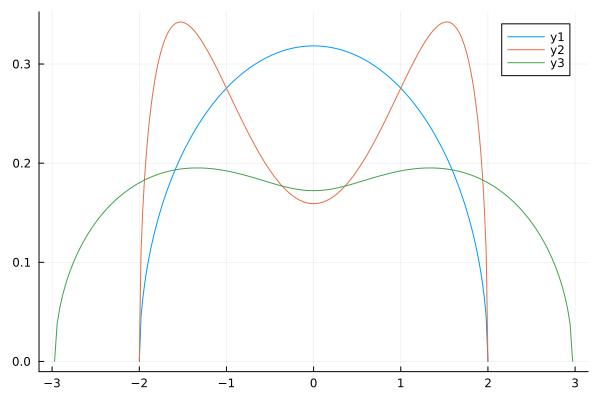

In [132]:
# Free addition of standard semicircle with a different measure that is "well behaved".
ψ_a_k = [1/pi]
ψ_b_k = [1/pi, 0.0, 1/(2*pi)]
@time ψ_c_k, supp_c = FreeAdditionSqrt(ψ_a_k, ψ_b_k, (-2,2), (-2,2);
    m=10, maxterms=20, tolcomp=1+10^-6, tolbisect = 10^-6, maxitsbisect=40)

PlotSqrtMeasure(ψ_a_k, (-2,2))
PlotSqrtMeasure!(ψ_b_k, (-2,2))
PlotSqrtMeasure!(ψ_c_k, supp_c)

  0.033585 seconds (85.65 k allocations: 7.224 MiB, 35.96% compilation time)


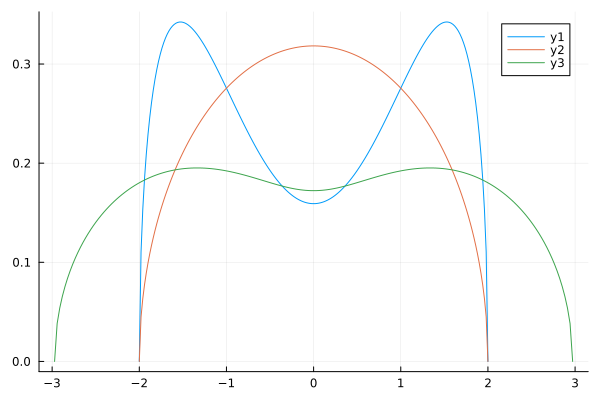

In [38]:
# Same as above, with the measures swapped. As expected, the same output is shown.
ψ_a_k = [1/pi, 0.0, 1/(2*pi)]
ψ_b_k = [1/pi]
@time ψ_c_k, supp_c = FreeAdditionSqrt(ψ_a_k, ψ_b_k, (-2,2), (-2,2);
    m=10, maxterms=20, tolcomp=1, tolbisect = 10^-6, maxitsbisect=40)

PlotSqrtMeasure(ψ_a_k, (-2,2))
PlotSqrtMeasure!(ψ_b_k, (-2,2))
PlotSqrtMeasure!(ψ_c_k, supp_c)

  2.288402 seconds (2.38 M allocations: 154.714 MiB, 1.78% gc time, 80.64% compilation time)


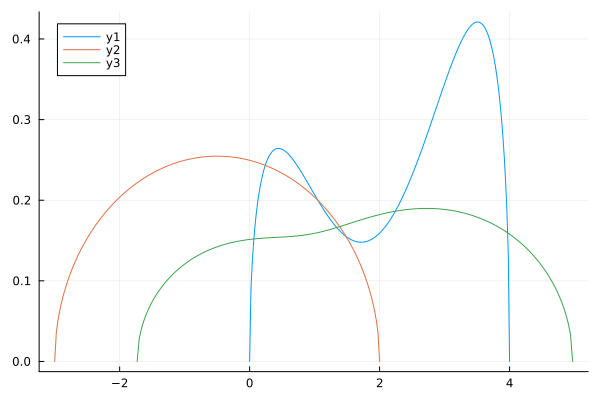

In [39]:
# Free addition of a semicircle that is off center with an asymmetrically distributed measure.
ψ_x = x -> ((x-2)^2+1 + ((x-2)^3)/4)/(2*pi)
ψ_x_expand = x -> ψ_x(M_ab(x, 0, 4))
P = ChebyshevU()
ψ_k = expand(P, ψ_x_expand).args[2]
ψ_a_k = ψ_k[1:3]

ψ_x = x -> 4/(5*pi)
ψ_x_expand = x -> ψ_x(M_ab(x, -3, 2))
P = ChebyshevU()
ψ_k = expand(P, ψ_x_expand).args[2]
ψ_b_k = ψ_k[1:1]

@time ψ_c_k, supp_c = FreeAdditionSqrt(ψ_a_k, ψ_b_k , (0,4), (-3,2);
    m=10, maxterms=20, tolcomp=1+10^-9, tolbisect = 10^-6, maxitsbisect=40)

PlotSqrtMeasure(ψ_a_k, (0,4))
PlotSqrtMeasure!(ψ_b_k, (-3,2))
PlotSqrtMeasure!(ψ_c_k, supp_c)

  3.137946 seconds (3.01 M allocations: 189.231 MiB, 4.14% gc time, 90.35% compilation time)


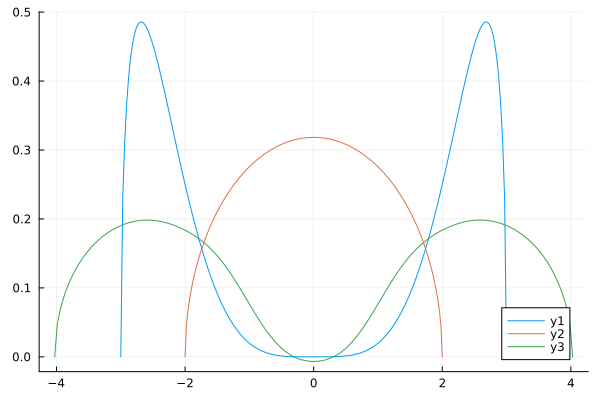

In [117]:
# Free addition of semicircle with a measure which is less "well behaved". The shape is correct, but the function
# should be non negative everywhere
ψ_x = x -> (16 * x^4) / (243 * pi)
ψ_x_expand = x -> ψ_x(M_ab(x, -3, 3))
P = ChebyshevU()
ψ_k = expand(P, ψ_x_expand).args[2]
ψ_a_k = ψ_k[1:5]
ψ_b_k = [1/pi]

@time ψ_c_k, supp_c = FreeAdditionSqrt(ψ_a_k, ψ_b_k , (-3,3), (-2,2);
    m=20, maxterms=30, tolcomp=1+10^-6, tolbisect = 10^-9, maxitsbisect=50)

PlotSqrtMeasure(ψ_a_k, (-3,3))
PlotSqrtMeasure!(ψ_b_k, (-2,2))
PlotSqrtMeasure!(ψ_c_k, supp_c)

#investigate why the expansion is bad for m=22 and beyond - maybe sometime

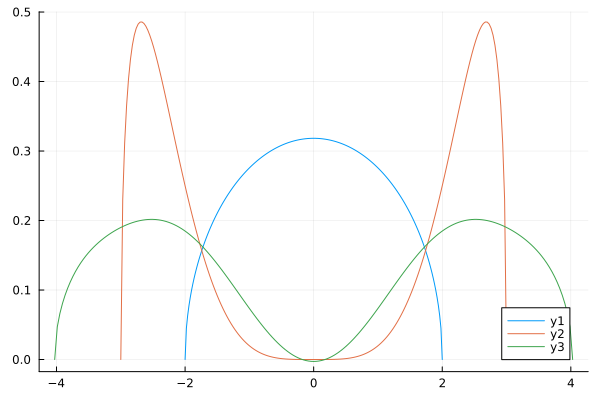

In [118]:
# Same as above except swapped
ψ_x = x -> (16 * x^4) / (243 * pi)
ψ_x_expand = x -> ψ_x(M_ab(x, -3, 3))
P = ChebyshevU()
ψ_k = expand(P, ψ_x_expand).args[2]
ψ_a_k = [1/pi]
ψ_b_k = ψ_k[1:5]

ψ_c_k, supp_c = FreeAdditionSqrt(ψ_a_k, ψ_b_k , (-2,2), (-3,3);
    m=10, maxterms=30, tolcomp=1+10^-6, tolbisect = 10^-9, maxitsbisect=50)

PlotSqrtMeasure(ψ_a_k, (-2,2))
PlotSqrtMeasure!(ψ_b_k, (-3,3))
PlotSqrtMeasure!(ψ_c_k, supp_c)

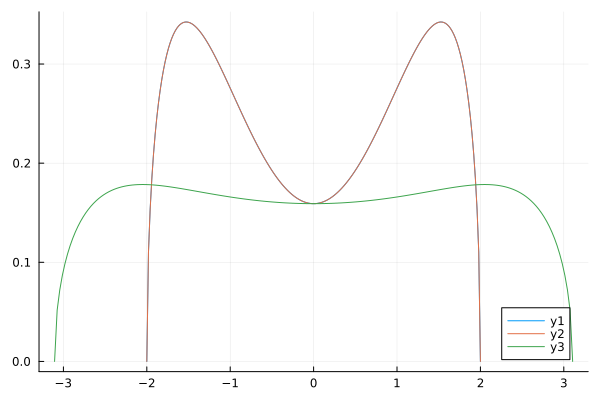

In [119]:
# Free addition of a measure with itself
ψ_a_k = [1/pi, 0.0, 1/(2*pi)]
supp_a = (-2, 2)
ψ_b_k = [1/pi, 0.0, 1/(2*pi)]
supp_b = (-2, 2)
ψ_c_k, supp_c = FreeAdditionSqrt(ψ_a_k, ψ_b_k, supp_a, supp_b;
    m=10, maxterms=20, tolcomp=1+10^-6, tolbisect = 10^-6, maxitsbisect=40)
PlotSqrtMeasure(ψ_a_k, supp_a)
PlotSqrtMeasure!(ψ_b_k, supp_b)
PlotSqrtMeasure!(ψ_c_k, supp_c)

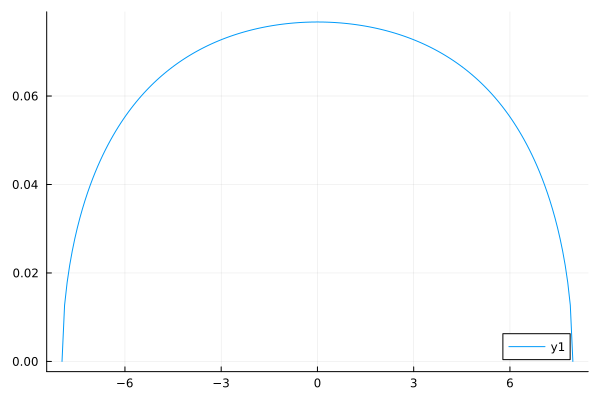

In [134]:
# Attempt to repeatedly convolute a measure with itself
# to see the free central limit theorem in action
ψ_a_k = [1/pi, 0.0, 1/(2*pi)]
supp_a = (-2, 2)
ψ_b_k = [1/pi, 0.0, 1/(2*pi)]
supp_b = (-2, 2)
for i=1:10
    ψ_b_k, supp_b = FreeAdditionSqrt(ψ_a_k, ψ_b_k, supp_a, supp_b;
    m=10, maxterms=20, tolcomp=1+10^-6, tolbisect = 10^-6, maxitsbisect=40)
end
PlotSqrtMeasure(ψ_b_k, supp_b)
# Looks like a semicircle after 10 convolutions.

Everything below this point is testing code and junk

In [125]:


ψ_a_k = [1/pi, 0.0, 1/(2*pi)]
supp_a = (-2, 2)
ψ_b_k = [0.2049610746035231, 6.018991130096466e-16, 0.04997727400915625, -2.371647532359365e-15, 0.0038828735435284555, 8.39149032788726e-15, -0.00031899828201653824, -3.063687668873302e-14, -2.087528756959434e-5, 2.04522594530056e-13, 9.513666258341495e-6, -1.0954486781526299e-12, -6.096596873805508e-7, 3.012174221398702e-12, -2.2156344492191138e-7, -3.985944563549044e-12, 5.1139484294649484e-8, 8.539327078682122e-12, 1.060251599539213e-9, -3.8449419793424594e-11]
supp_b = (-3.106052081347931, 3.106052081347931)
m=10

maxterms=20
tolcomp=1+10^-6
tolbisect = 10^-9
maxitsbisect=40

    G_a = z -> CauchyTransformSqrt(Complex(z), ψ_a_k, supp_a[1], supp_a[2]; maxterms)
    G_b = z -> CauchyTransformSqrt(Complex(z), ψ_b_k, supp_b[1], supp_b[2]; maxterms)
    InvG_a = z -> InvCauchyTransformSqrt(Complex(z), ψ_a_k, supp_a[1], supp_a[2]; maxterms, tol=tolcomp)
    InvG_b = z -> InvCauchyTransformSqrt(Complex(z), ψ_b_k, supp_b[1], supp_b[2]; maxterms, tol=tolcomp)
    dG_a = z -> dCauchyTransformSqrt(Complex(z), ψ_a_k, supp_a[1], supp_a[2]; maxterms)
    dG_b = z -> dCauchyTransformSqrt(Complex(z), ψ_b_k, supp_b[1], supp_b[2]; maxterms)
    
   
    a_0 = max(real(G_a(Complex(supp_a[1]))), real(G_b(Complex(supp_b[1]))))
    b_0 = min(real(G_a(Complex(supp_a[2]))), real(G_b(Complex(supp_b[2]))))  
    dInvG_a = z -> 1 / (dG_a(InvG_a(z)))
    dInvG_b = z -> 1 / (dG_b(InvG_b(z)))
    dInvG_c = z -> dInvG_a(z) + dInvG_b(z) + 1/z^2
    dInvG_c_real = z -> real(dInvG_c(Complex(z)))
    ξ_a = bisection(dInvG_c_real, a_0, a_0/2; tol=tolbisect, maxits=maxitsbisect)
    ξ_b = bisection(dInvG_c_real, b_0/2, b_0; tol=tolbisect, maxits=maxitsbisect)
    InvG_c = y -> InvG_a(y) + InvG_b(y) - 1/y
    supp_c = (real(InvG_c(ξ_a)), real(InvG_c(ξ_b)))

    
    d_M = vec(unitcirclenodes(m)*[x for x in chebyshevnodes(-1,1,2*m+1) if x > eps()]')
    z_μ_M = [M_ab(J(x), supp_c[1], supp_c[2]) for x in d_M if imag(x) >= eps()]
    y_M = [G_a(y) for y in z_μ_M]
    y_M = [y for y in y_M if length(InvG_b(y)) == 1] #35
    y_M = [y for y in y_M if isapprox(G_b(InvG_b(y)), y)]
    y_m = PrunePoints(y_M, InvG_a, InvG_b)
    ψ_c_k = RecoverMeasureSqrt(InvG_a, InvG_b, supp_c, y_m)



30-element Vector{Float64}:
  0.16153278827002593
 -2.2721100881002608e-14
  0.025662247751151133
 -5.078161690663266e-14
  0.0016776264832311346
  7.65847979643071e-15
 -3.843111785928516e-5
 -1.215717294255605e-13
 -8.455170060973814e-6
  7.418569279679444e-13
  6.37545526734214e-7
 -5.184461511012792e-12
  7.32448135474262e-8
  ⋮
  1.6945386021848544e-10
 -1.3989846734253637e-10
  1.0211152346503362e-10
  1.7886040521474003e-10
 -1.3077630387539579e-10
 -8.032821272647292e-11
  4.3497007192407473e-11
  1.9147488907531457e-10
 -1.2817803278716941e-10
 -2.5923736642028537e-10
  1.8577148194876814e-10
 -8.851786018910275e-12

19
degree polynomial inversion


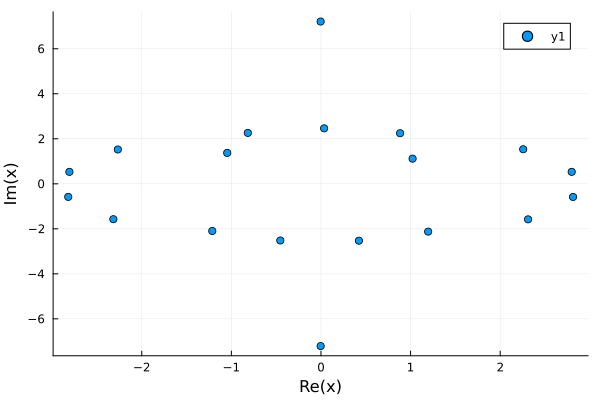

In [113]:

test = z -> InvCauchyTransformSqrtAll(Complex(z), ψ_b_k, supp_b[1], supp_b[2]; maxterms, tol=1+10^-6)

scatter(test(0.15216439158583048 + 0.9758593756312623im))


In [30]:
# unused
function InversePolynomial(P, z)
    last = P[end]
    n = length(P) - 1
    P = P / last # make monic
    # lazy convert to complex
    C = zeros(Complex, n, n)
    for i=1:n-1
        C[i+1,i] = 1
        C[i,n] = -P[i]
    end
    C[1, n] += z/last
    eigvals(C)
end

InversePolynomial (generic function with 1 method)

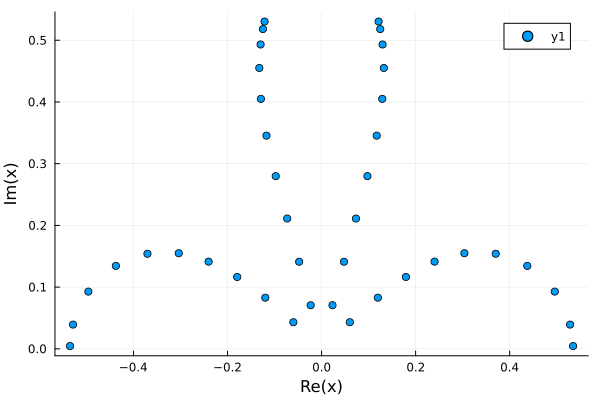

In [31]:
m=10
d_M = vec(unitcirclenodes(m)*[x for x in chebyshevnodes(-1,1,2*m+1) if x > eps()]')

z_μ_M = [M_ab(J(x), supp_c[1], supp_c[2]) for x in d_M if imag(x) >= eps()]
y_M = [G_b(y) for y in z_μ_M]
y_M = [y for y in y_M if isapprox(G_a(InvG_a(y)), y)]
scatter(y_M)

In [32]:
# functions for plotting the image of cauchy transform
function CauchyTransformImage(G, supp, eps = 0.00001, numpoints=200)
    upperplane = vec(G.([x - eps * 1im for x = supp[1]:1/numpoints:supp[2]]))
    lowerplane = vec(G.([x + eps * 1im for x = supp[2]:-1/numpoints:supp[1]]))
    plot([upperplane;lowerplane])
end
function CauchyTransformImage!(G, supp, eps = 0.00001, numpoints=200)
    upperplane = vec(G.([x - eps * 1im for x = supp[1]:1/numpoints:supp[2]]))
    lowerplane = vec(G.([x + eps * 1im for x = supp[2]:-1/numpoints:supp[1]]))
    plot!([upperplane;lowerplane])
end

CauchyTransformImage! (generic function with 3 methods)

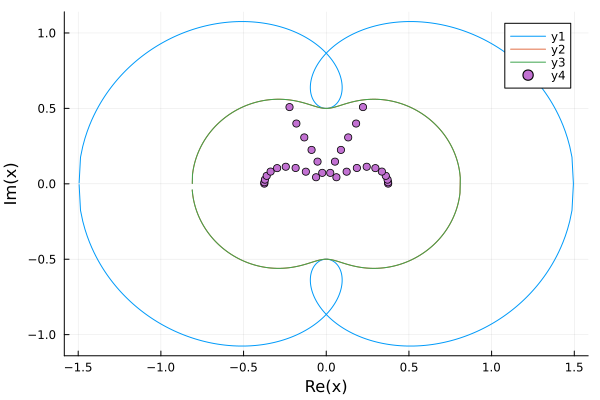

In [123]:
CauchyTransformImage(z -> CauchyTransformSqrt(Complex(z), ψ_a_k, supp_a[1], supp_a[2]), supp_a)
CauchyTransformImage!(z -> CauchyTransformSqrt(Complex(z), ψ_b_k, supp_b[1], supp_b[2]), supp_b)
CauchyTransformImage!(z -> CauchyTransformSqrt(Complex(z), ψ_c_k, supp_c[1], supp_c[2]), supp_c)
#scatter!(d_M)
scatter!(y_M)
#scatter!(y_m)

In [111]:
function InvCauchyTransformSqrtAll(z, ψ_k, a, b; maxterms=20, tol=1)   
# test function whose name is misleading
    P = ψ_k[1:min(length(ψ_k),maxterms)]
    n = min(length(ψ_k),maxterms)
    while abs(ψ_k[n]) < 10^-9
        n -= 1
    end
    println(n)
    println("degree polynomial inversion")
    P ./= P[n]
    C = zeros(Complex, n, n)
    for i=1:n-1
        C[i+1,i] = 1
        C[i+1,n] = -P[i]
    end
    C[1, n] = z/(pi * ψ_k[n])
    s = eigvals(C)
end

InvCauchyTransformSqrtAll (generic function with 1 method)